## **1D Heat Equation Physics-Informed Neural Network (PINN)**

---
In this notebook, we tackle an inverse problem involving the heat equation, a fundamental partial differential equation governing thermal diffusion in materials. Using a Physics-Informed Neural Network (PINN), we aim to simultaneously learn the temperature field

$T(x,t)$ and the unknown thermal parameters of the system.

Unlike a standard forward simulation; where the thermal diffusivity is known and we solve for $T(x,t)$, here we attempt to discover the underlying thermal behavior directly from data, while ensuring that the learned solution obeys the physics of heat transfer everywhere in the domain.

**Problem Setup** We consider the one-dimensional heat equation on a spatial domain $x \in [0,L]$ over a time interval $t \in [0,T]$

$$ T_t(x,t) - \alpha\,T_{xx}(x,t) - Q(x,t) = 0$$

where:


*   $T(x,t)$ is the temperature field,
*   $\alpha$ is the **thermal diffusivity**,
*   $Q(x,t)$ is an internal heat-generation term

In this inverse problem, the thermal diffusivity $\alpha$ is treated as unknown and must be learned from sparse and possibly noisy temperature measurements.

We also assume initial and boundary conditions:


*   **Initial condition:** $T(x,0)=T_0(x)$
* **Boundary conditions:** $T(0,t)=T(L,t)$







In [186]:
# Importing other libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Physical Set-up

In [187]:
# --------------------------------------------------------
# PHYSICAL SETUP (HEAT EQUATION)
# --------------------------------------------------------
# we define a simple analytic solution of the 1D heat equation on [0, L] x [0, T_final]
#   to generate synthetic temperature data for (x, t).

L = 1.0          # length of the 1D spatial domain
T_final = 1.0    # final time

# True physical diffusivity used to generate the synthetic true solution
alpha_true = 0.2

# Trainable diffusivity parameter used by the PINN
alpha_param = torch.nn.Parameter(torch.tensor([0.05], device=device))

Q0 = 0 # internal heat source term; set to 0 for now

def analytic_solution(x, t):
    # Use the true alpha for the analytic solution
    return torch.exp(-(np.pi**2 * alpha_true / L**2) * t) * torch.sin(np.pi * x / L)

def heat_source(x, t):
    return torch.zeros_like(x)


### Generate noisy data


In [188]:
# --------------------------------------------------------
# GENERATE SYNTHETIC "MEASUREMENT" DATA
# --------------------------------------------------------
#  generate noisy temperature samples at random (x, t) locations.

torch.manual_seed(0)

n_data = 20  # number of synthetic temperature measurements
x_data = torch.rand(n_data, 1) * L            # x in [0, L]
t_data = torch.rand(n_data, 1) * T_final      # t in [0, T_final]

T_clean = analytic_solution(x_data, t_data)
noise_std = 0.01
T_data = T_clean + noise_std * torch.randn_like(T_clean)

x_data = x_data.to(device)
t_data = t_data.to(device)
T_data = T_data.to(device)


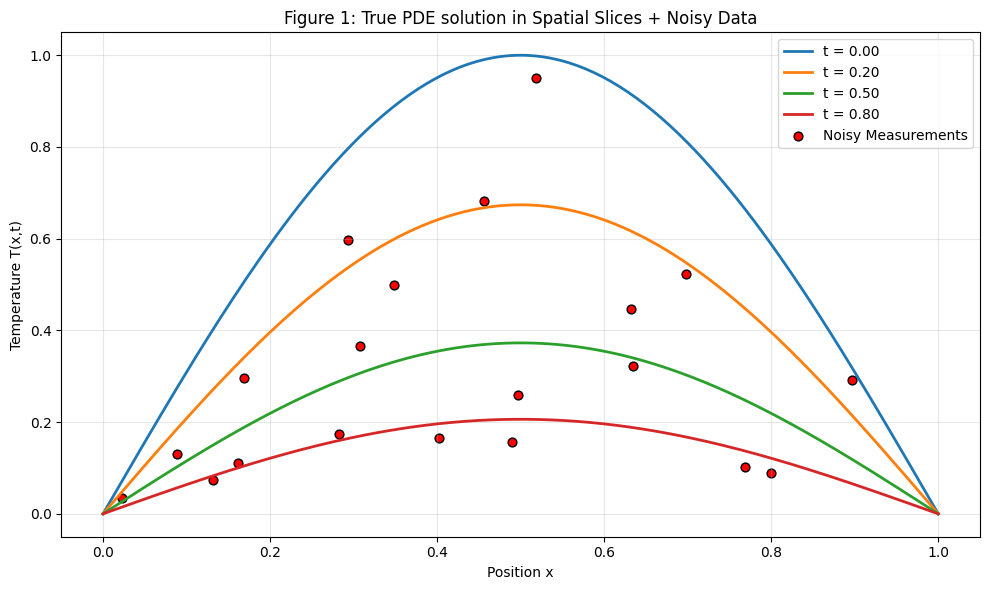

In [189]:
# --------------------------------------------------------
# MULTIPLE TIME-SLICE CURVE PLOT + NOISY DATA
# --------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# Choose time slices to want to plot
times_to_plot = [0.0, 0.2*T_final, 0.5*T_final, 0.8*T_final]

x = torch.linspace(0, L, 200).view(-1, 1)

plt.figure(figsize=(10, 6))

for t0 in times_to_plot:
    t_val = torch.full_like(x, t0)
    T_slice = analytic_solution(x, t_val).detach().cpu().numpy()
    plt.plot(
        x.cpu().numpy(),
        T_slice,
        linewidth=2,
        label=f"t = {t0:.2f}"
    )

# Plot noisy data on top
plt.scatter(
    x_data.cpu().numpy(),
    T_data.cpu().numpy(),
    c='red',
    s=40,
    edgecolor='k',
    label='Noisy Measurements'
)

plt.xlabel("Position x")
plt.ylabel("Temperature T(x,t)")
plt.title("Figure 1: True PDE solution in Spatial Slices + Noisy Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### **Figure 1: True PDE Solution: Spatial Slices with Noisy Data.**  
While the heatmap shows the global behavior of the solution, the spatial slices isolate $T(x,t)$ at specific times, clearly revealing the sinusoidal shape, the gradual decay in amplitude, and how the noisy measurements align with the true temperature profiles.


---



## Define a Neural Network


---



In [190]:
# --------------------------------------------------------
# DEFINE a NEURAL NETWORK
# --------------------------------------------------------
#  Net takes 2D input [x, t] and outputs T(x,t).

class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        net = []
        for i in range(len(layers) - 1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                net.append(nn.Tanh())
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        # x, t: (N, 1)
        XT = torch.cat([x, t], dim=1)  # (N, 2)
        return self.net(XT)


# Network architecture: 2 inputs (x,t), several hidden layers, 1 output (T)
layers = [2, 20, 20, 20, 1]
model = Net(layers).to(device)

In [191]:
# --------------------------------------------------------
# PINN LOSS COMPONENTS
# --------------------------------------------------------
mse_loss = nn.MSELoss()

def pde_residual(x_f, t_f):


    #   PDE residual = T_t - alpha T_xx - Q(x,t)  (1D heat equation).

    x_f = x_f.clone().detach().requires_grad_(True).to(device)
    t_f = t_f.clone().detach().requires_grad_(True).to(device)

    T = model(x_f, t_f)

# First derivative w.r.t. t
    T_t = torch.autograd.grad(
        T, t_f,
        grad_outputs=torch.ones_like(T),
        create_graph=True,
        retain_graph=True
    )[0]

# First derivative w.r.t. x
    T_x = torch.autograd.grad(
        T, x_f,
        grad_outputs=torch.ones_like(T),
        create_graph=True,
        retain_graph=True
    )[0]

# Second derivative w.r.t. x
    T_xx = torch.autograd.grad(
        T_x, x_f,
        grad_outputs=torch.ones_like(T_x),
        create_graph=True,
        retain_graph=True
    )[0]

    Q = heat_source(x_f, t_f)

    res = T_t - alpha_param * T_xx - Q

    return res


def initial_condition(x_ic):

      #  Enforce: T(x,0) = sin(pi x / L)

    return analytic_solution(x_ic, torch.zeros_like(x_ic))


# Training Objective


---



Our goal is to simultaneously learn:

The neural network parameters $W$ that represent the temperature field $T(x,t;W)$, and the physical parameter $\alpha$ (thermal diffusivity), treated as a trainable variable, that we defined as $\alpha$_learn

Such that the network fits the observed temperature data:

*   The heat equation residual is minimized throughout the domain
*   The initial and boundary conditions are satisfied
*   We correctly discover the underlying thermal diffusivity governing the system
$$\qquad$$

The Physics-Informed Neural Network (PINN) enforces the governing PDE,
initial condition, boundary conditions, and data fidelity through a
weighted loss function composed of four terms.
$$\qquad$$


**PDE Loss:**
The PDE residual is defined as
$$ R(x,t)=T_t(x,t)- \alpha\,T_{xx}(x,t)- Q(x,t)$$
and the physics loss is the mean-squared residual over all collocation points:
$$
L_{\text{PDE}}
=
\frac{1}{N_f}
\sum_{i=1}^{N_f}
\left[
T_t\!\left(x_f^{(i)}, t_f^{(i)}\right)
- \alpha\,T_{xx}\!\left(x_f^{(i)}, t_f^{(i)}\right)
- Q\!\left(x_f^{(i)}, t_f^{(i)}\right)
\right]^2 .
$$
$$\qquad$$

**Initial Condition Loss:**
Given the initial condition $T(x,0) = T_0(x)$ the loss is

$$L_{IC}
=
\frac{1}{N_{IC}}
\sum_{i=1}^{N_{\text{IC}}}
\left[
T\!\left( x_{IC}^{(i)}, 0 \right)
-
T_0\!\left( x_{IC}^{(i)} \right)
\right]^2 .
$$

$$\qquad$$

**Boundary Condition Loss:**
Assuming Dirichlet boundary conditions $T(0,t) = T_{bc}\;$ and
$\;T(L,t) = T_{bc}$

the boundary loss becomes
$$L_{BC}
=
\frac{1}{N_{BC}}
\sum_{i=1}^{N_{BC}}
\left[
\left( T(0, t_{\text{BC}}^{(i)}) - T_{\text{bc}} \right)^2
+
\left( T(L, t_{\text{BC}}^{(i)}) - T_{\text{bc}} \right)^2
\right]$$
$$\qquad$$


**Data Loss:**
Given noisy temperature measurements $(x_d^{(i)}, t_d^{(i)}, T_d^{(i)})$, the data loss is
$$L_{data}
=
\frac{1}{N_{data}}
\sum_{i=1}^{N_{data}}
\left[
T\!\left( x_d^{(i)}, t_d^{(i)} \right)
- T_d^{(i)}
\right]^2 .
$$
$$\qquad$$



**Total Loss:**
The complete PINN loss function is a weighted sum of all components:
$$
L_{total}
=
\lambda_{PDE}\,L_{PDE}
+
\lambda_{IC}\,L_{IC}
+
\lambda_{BC}\,L_{BC}
+
\lambda_{data}\, L_{data}$$

The coefficients $\lambda_{PDE}, \lambda_{IC}, \lambda_{BC}, \lambda_{data}$
control the balance between physics enforcement and data fitting.


In [192]:
# --------------------------------------------------------
# TRAINING FUNCTION
# --------------------------------------------------------
#   - Inputs are (x, t) for data and residual points.
#   - Explicit initial and boundary condition losses.
#   - The physics loss term uses pde_residual.
#   - NEW: alpha_history returns the evolution of α over epochs.

def train(model, optimizer, epochs, eta_phys,
          N_f=200, N_ic=50, N_bc=50):

    data_losses = []
    physics_losses = []
    ic_losses = []
    bc_losses = []
    alpha_history = []      # <--- NEW: track α every epoch

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # -------------------------
        # Data loss
        # -------------------------
        T_pred_data = model(x_data, t_data)
        loss_data = mse_loss(T_pred_data, T_data)

        # -------------------------
        # Physics loss
        # -------------------------
        x_f = torch.rand(N_f, 1) * L
        t_f = torch.rand(N_f, 1) * T_final
        x_f = x_f.to(device)
        t_f = t_f.to(device)

        x_f.requires_grad_(True)
        t_f.requires_grad_(True)

        T_f = model(x_f, t_f)
        T_t_f = torch.autograd.grad(
            T_f, t_f,
            grad_outputs=torch.ones_like(T_f),
            create_graph=True, retain_graph=True
        )[0]
        T_x_f = torch.autograd.grad(
            T_f, x_f,
            grad_outputs=torch.ones_like(T_f),
            create_graph=True, retain_graph=True
        )[0]
        T_xx_f = torch.autograd.grad(
            T_x_f, x_f,
            grad_outputs=torch.ones_like(T_x_f),
            create_graph=True, retain_graph=True
        )[0]

        Q_f = heat_source(x_f, t_f)
        pde_res_f = T_t_f - alpha_param * T_xx_f - Q_f
        loss_phys = mse_loss(pde_res_f, torch.zeros_like(pde_res_f))

        # -------------------------
        # Initial condition: T(x,0)
        # -------------------------
        x_ic = torch.rand(N_ic, 1) * L
        t_ic = torch.zeros_like(x_ic)
        x_ic = x_ic.to(device)
        t_ic = t_ic.to(device)

        T_pred_ic = model(x_ic, t_ic)
        T_true_ic = initial_condition(x_ic)
        loss_ic = mse_loss(T_pred_ic, T_true_ic)

        # -------------------------
        # Boundary condition: T(0,t), T(L,t)
        # -------------------------
        t_bc = torch.rand(N_bc, 1) * T_final
        t_bc = t_bc.to(device)

        x_bc0 = torch.zeros_like(t_bc).to(device)
        x_bcL = (L * torch.ones_like(t_bc)).to(device)

        T_bc0 = model(x_bc0, t_bc)
        T_bcL = model(x_bcL, t_bc)

        loss_bc = mse_loss(T_bc0, torch.zeros_like(T_bc0)) + \
                  mse_loss(T_bcL, torch.zeros_like(T_bcL))

        # -------------------------
        # Total loss
        # -------------------------
        total_loss = loss_data + eta_phys * loss_phys + loss_ic + loss_bc

        total_loss.backward()
        optimizer.step()

        # -------------------------
        # Logging
        # -------------------------
#  stores the losses and the learned α at each epoch and occasionally prints training progress,
#  to later analyze, plot, and verify how the PINN learned during training.
        data_losses.append(loss_data.item())
        physics_losses.append(loss_phys.item())
        ic_losses.append(loss_ic.item())
        bc_losses.append(loss_bc.item())

        alpha_history.append(alpha_param.detach().cpu().item())   # saves the current learned value of α to track how α evolves across training.

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:5d} | "
                  f"Total: {total_loss.item():.4e} | "
                  f"Data: {loss_data.item():.4e} | "
                  f"PDE: {loss_phys.item():.4e} | "
                  f"IC: {loss_ic.item():.4e} | "
                  f"BC: {loss_bc.item():.4e}")

    return data_losses, physics_losses, ic_losses, bc_losses, alpha_history


In [193]:
# --------------------------------------------------------
# TRAIN MODEL
# --------------------------------------------------------
epochs = 5000
eta_phys = 1

optimizer = optim.Adam(
    list(model.parameters()) + [alpha_param],
    lr=1e-3
)

data_losses, physics_losses, ic_losses, bc_losses, alpha_history = train(
    model, optimizer, epochs, eta_phys
)


Epoch     0 | Total: 8.1644e-01 | Data: 2.0414e-01 | PDE: 9.9158e-04 | IC: 5.9779e-01 | BC: 1.3525e-02
Epoch   500 | Total: 1.3132e-02 | Data: 3.2621e-03 | PDE: 5.5431e-03 | IC: 2.1079e-03 | BC: 2.2193e-03
Epoch  1000 | Total: 2.9616e-03 | Data: 2.8375e-04 | PDE: 1.2677e-03 | IC: 4.4822e-04 | BC: 9.6199e-04
Epoch  1500 | Total: 1.7848e-03 | Data: 9.4139e-05 | PDE: 8.3308e-04 | IC: 2.6042e-04 | BC: 5.9719e-04
Epoch  2000 | Total: 8.7629e-04 | Data: 1.1247e-04 | PDE: 5.0938e-04 | IC: 6.4166e-05 | BC: 1.9027e-04
Epoch  2500 | Total: 4.5207e-04 | Data: 7.2012e-05 | PDE: 2.1102e-04 | IC: 4.8454e-05 | BC: 1.2058e-04
Epoch  3000 | Total: 3.7834e-04 | Data: 8.3787e-05 | PDE: 1.6317e-04 | IC: 5.6234e-05 | BC: 7.5154e-05
Epoch  3500 | Total: 2.1511e-04 | Data: 7.1225e-05 | PDE: 9.1004e-05 | IC: 1.2395e-05 | BC: 4.0483e-05
Epoch  4000 | Total: 1.8811e-04 | Data: 7.5561e-05 | PDE: 8.2891e-05 | IC: 8.8261e-06 | BC: 2.0827e-05
Epoch  4500 | Total: 6.1650e-04 | Data: 1.7129e-04 | PDE: 6.9101e-05 | IC


# Visualization




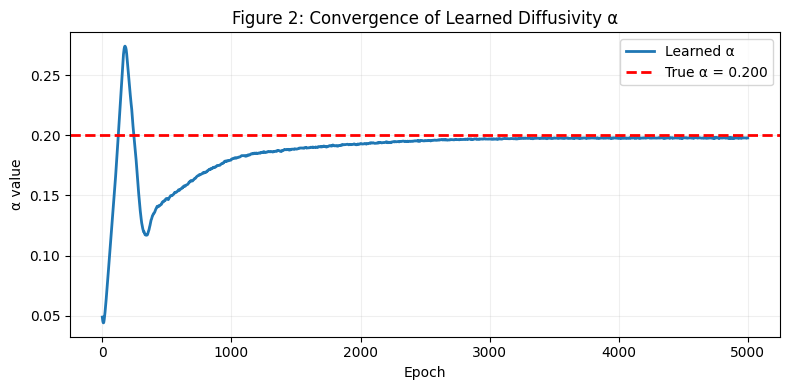

In [194]:
plt.figure(figsize=(8,4))
plt.plot(alpha_history, label='Learned α', linewidth=2)
plt.axhline(alpha_true, color='r', linestyle='--', linewidth=2,
            label=f'True α = {alpha_true:.3f}')
plt.xlabel("Epoch")
plt.ylabel("α value")
plt.title("Figure 2: Convergence of Learned Diffusivity α")
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

#### **Figure 2: Evalution of $\alpha$_learn during PINN Training**

Early oscillations reflect the model adjusting to both data noise and PDE constraints. As training progresses,
$\;\alpha\;$ settles near the true value, indicating that the PINN has identified the correct physical parameter from noisy observations.


---




Figure 3: Training loss components for the PINN


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

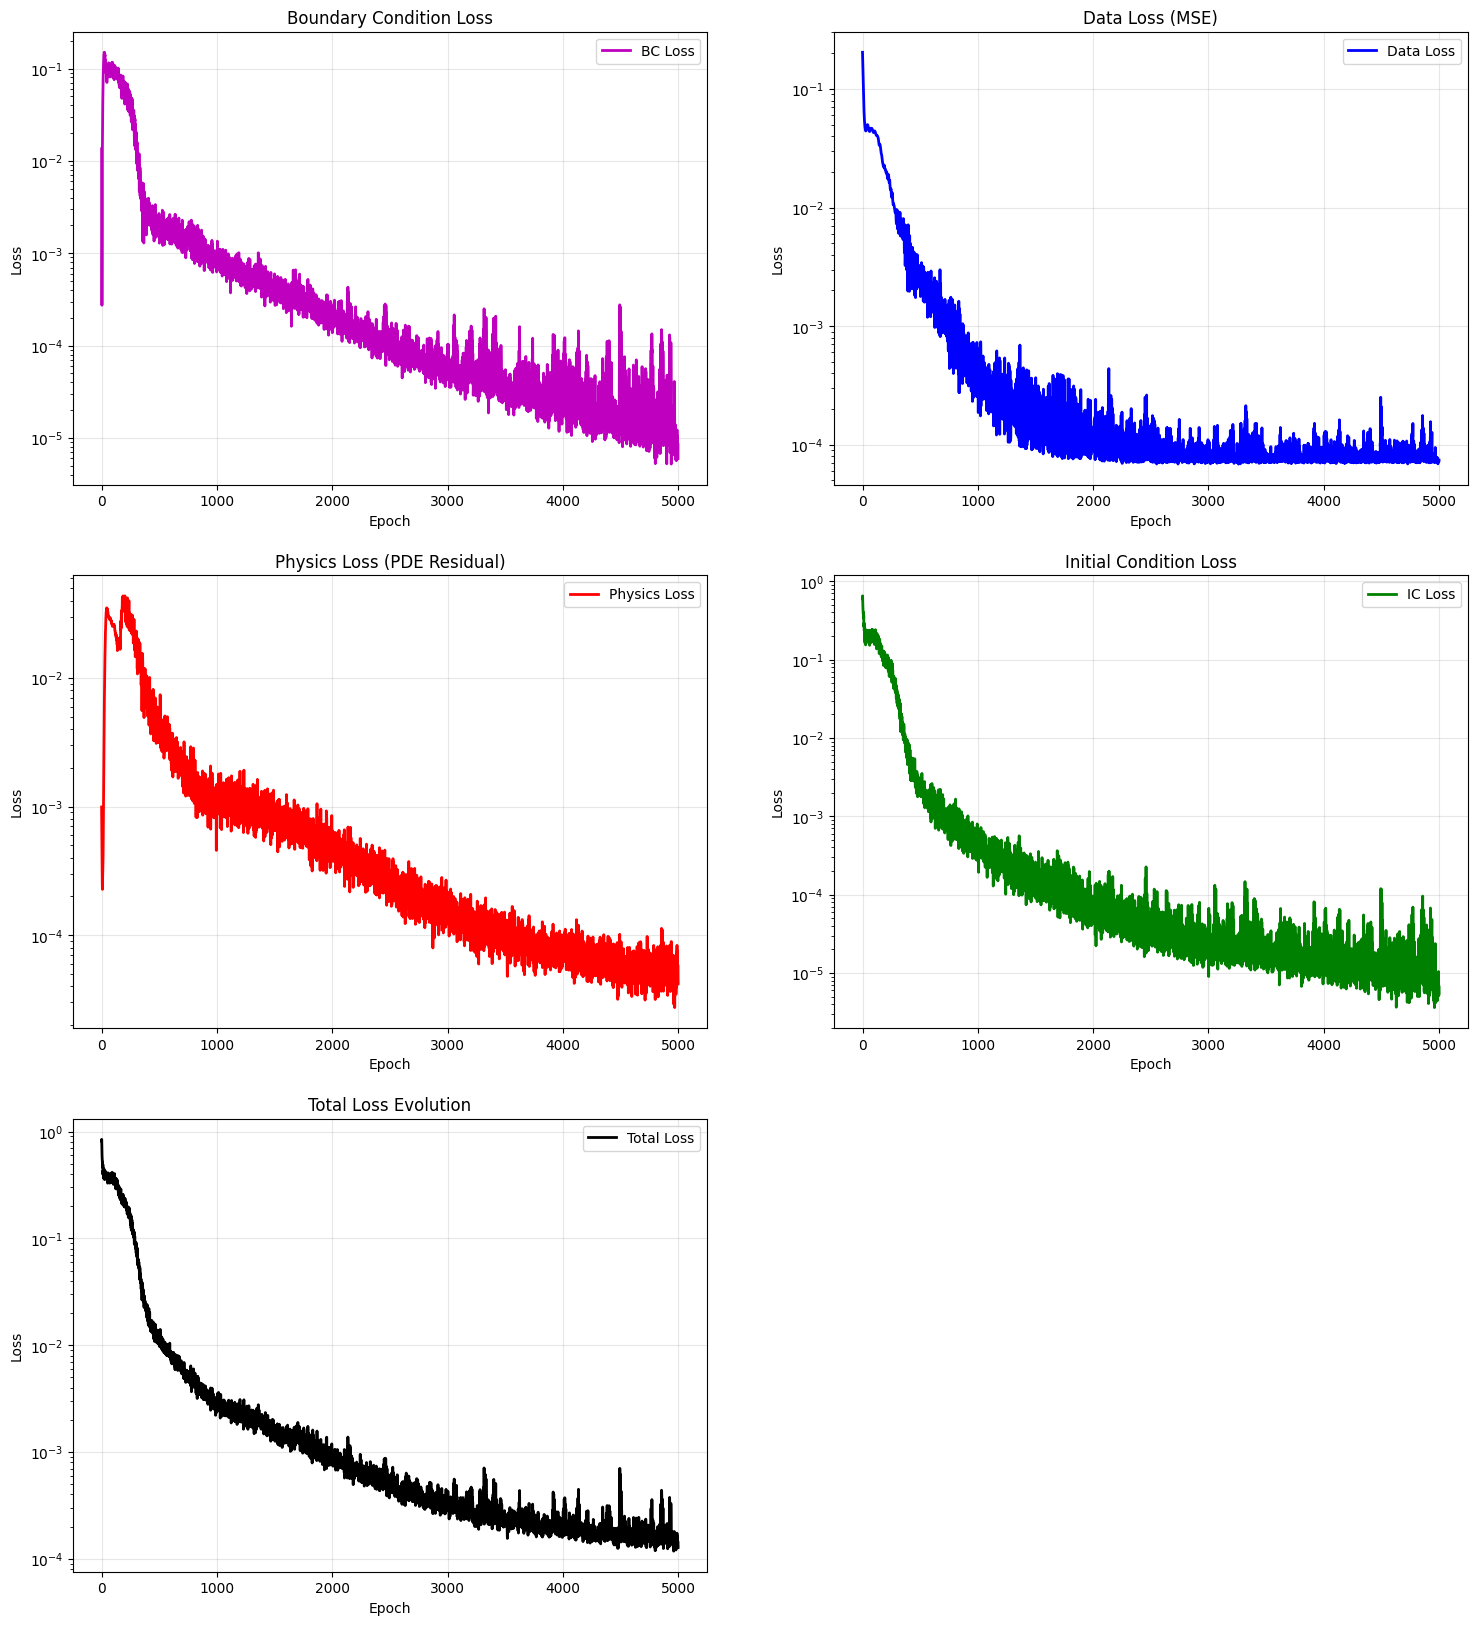

In [241]:
# ============================================
# Loss visualization for Heat Equation PINN
# ============================================

import matplotlib.pyplot as plt

# Reconstruct total loss from components
# ------ make sure eta_phys matches what was used in training ------ #
lambda_pde  = eta_phys
lambda_ic   = 1.0
lambda_bc   = 1.0
lambda_data = 1.0

num_epochs = len(data_losses)
epochs_range = range(num_epochs)

total_losses = [
    lambda_pde  * physics_losses[i] +
    lambda_ic   * ic_losses[i] +
    lambda_bc   * bc_losses[i] +
    lambda_data * data_losses[i]
    for i in range(num_epochs)
]

print("\n" + "="*60)
print("Figure 3: Training loss components for the PINN")
print("="*60)

# Create 2x3 grid: Total, PDE, Data, IC, BC
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# ---- Boundary condition loss ----
ax1.plot(epochs_range, bc_losses, 'm-', linewidth=2, label='BC Loss')
ax1.set_title('Boundary Condition Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# ---- Data loss ----
ax2.plot(epochs_range, data_losses, 'b-', linewidth=2, label='Data Loss')
ax2.set_title('Data Loss (MSE)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

# ---- Physics (PDE) loss ----
ax3.plot(epochs_range, physics_losses, 'r-', linewidth=2, label='Physics Loss')
ax3.set_title('Physics Loss (PDE Residual)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)
ax3.legend()

# ---- Initial condition loss ----
ax4.plot(epochs_range, ic_losses, 'g-', linewidth=2, label='IC Loss')
ax4.set_title('Initial Condition Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)
ax4.legend()


# ---- Total loss ----
ax5.plot(epochs_range, total_losses, 'k-', linewidth=2, label='Total Loss')
ax5.set_title('Total Loss Evolution')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')
ax5.set_yscale('log')
ax5.grid(True, alpha=0.3)
ax5.legend()


ax6.axis('off')




####  **Figure 3: Training loss components for the Physics-Informed Neural Network (PINN).**

This set of plots illustrates the evolution of all loss terms during training. Each curve is shown on a logarithmic scale, revealing how quickly the network fits the noisy data while simultaneously enforcing the governing heat equation and the imposed initial and boundary conditions. The steady downward trends and eventual stabilization of all components indicate that the PINN successfully learned a temperature field that is both data-consistent and physically accurate across the entire domain.


---



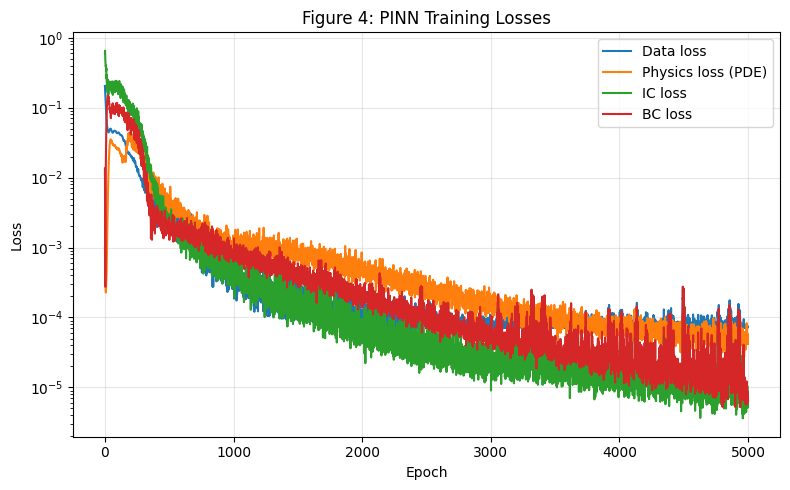

In [196]:
# --------------------------------------------------------
# VISUALIZATION
# --------------------------------------------------------
#   we now plot T(x,t) slices and compare to the analytic heat-equation solution.

# 1) Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(data_losses, label="Data loss")
plt.plot(physics_losses, label="Physics loss (PDE)")
plt.plot(ic_losses, label="IC loss")
plt.plot(bc_losses, label="BC loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Figure 4: PINN Training Losses")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



####  **Figure 4: PINN Training Loss.**

The combined loss plot provides a global view of how the different loss components decrease during training, while the individual subplots in **Figure 3** give a clearer, more detailed picture of the behavior of each component separately. Together, they provide a complete view of the training dynamics of the PINN.


---



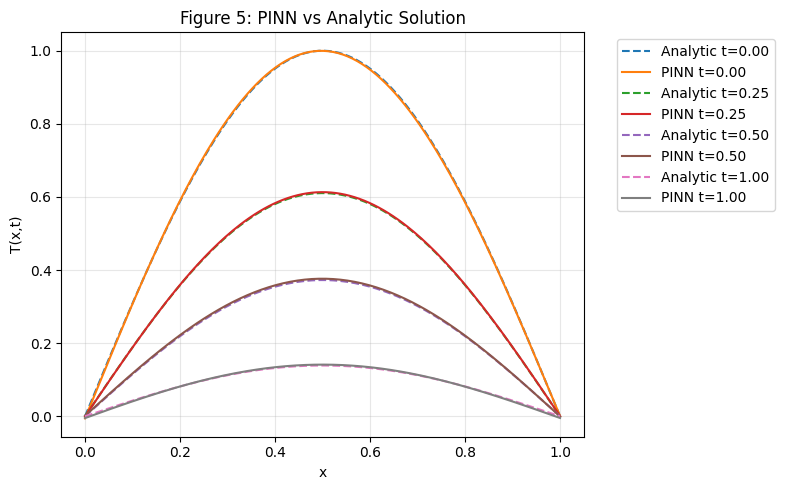

In [197]:
# Compare PINN vs analytic solution at several time slices

x_plot = torch.linspace(0, L, 200).view(-1, 1).to(device)
times_to_plot = [0.0, 0.25 * T_final, 0.5 * T_final, T_final]

plt.figure(figsize=(8,5))
for t_val in times_to_plot:
    t_plot = torch.full_like(x_plot, t_val).to(device)

    with torch.no_grad():
        T_pinn = model(x_plot, t_plot).cpu()
        T_true = analytic_solution(x_plot.cpu(), t_plot.cpu())

    plt.plot(x_plot.cpu().numpy(), T_true.numpy(),
             linestyle="--", label=f"Analytic t={t_val:.2f}")
    plt.plot(x_plot.cpu().numpy(), T_pinn.numpy(),
             linestyle="-", label=f"PINN t={t_val:.2f}")

plt.xlabel("x")
plt.ylabel("T(x,t)")
plt.title("Figure 5: PINN vs Analytic Solution")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

####  **Figure 5: PINN-Predicted vs Analytic Solution.**

 Each pair of curves (analytic vs. PINN) represents the temperature distribution across the spatial domain at a specific time. The near perfect overlap between the predicted and true curves demonstrates that the PINN accurately captures both the sinusoidal spatial structure and the temporal decay behavior of the heat equation, despite being trained on sparse noisy data.


---




Figure 6: Comparison of PINN Temperature with the True Heat Solution


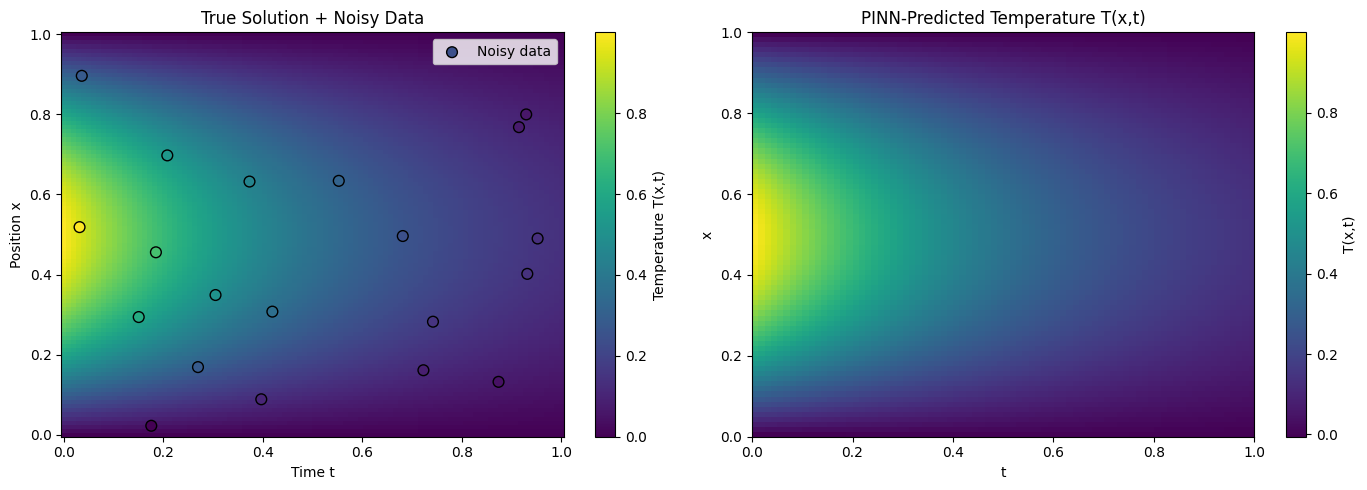

In [239]:
# --------------------------------------------------------
# SIDE-BY-SIDE HEATMAPS:
# Left  = True PDE solution + noisy data
# Right = PINN-predicted temperature field
# --------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===============================
# LEFT PLOT: TRUE PDE + NOISY DATA
# ===============================
ax = axes[0]

pcm = ax.pcolormesh(
    T_np,            # horizontal axis: time
    X_np,            # vertical axis: space
    T_exact_np,      # true temperature field
    shading='auto'
)
fig.colorbar(pcm, ax=ax, label='Temperature T(x,t)')

# noisy measurement points
ax.scatter(
    t_noisy_np, x_noisy_np,
    c=T_noisy_np,
    edgecolors='k',
    s=60,
    label='Noisy data'
)

ax.set_xlabel('Time t')
ax.set_ylabel('Position x')
ax.set_title('True Solution + Noisy Data')
ax.legend(loc='upper right')
ax.grid(False)


# ===================================
# RIGHT PLOT: PINN PREDICTED HEATMAP
# ===================================
print("\n" + "="*80)
print("Figure 6: Comparison of PINN Temperature with the True Heat Solution")
print("="*80)

# Build PINN prediction grid
Nx, Nt = 80, 80
x_grid = torch.linspace(0, L, Nx).view(-1, 1)
t_grid = torch.linspace(0, T_final, Nt).view(-1, 1)

Xg, Tg = torch.meshgrid(
    x_grid.squeeze(),
    t_grid.squeeze(),
    indexing="ij"
)

XT = torch.cat([Xg.reshape(-1,1), Tg.reshape(-1,1)], dim=1).to(device)

with torch.no_grad():
    T_pred_grid = model(XT[:,0:1], XT[:,1:2]).cpu().numpy()

T_pred_grid = T_pred_grid.reshape(Nx, Nt)

# Plot PINN heatmap
ax2 = axes[1]

im = ax2.imshow(
    T_pred_grid,
    extent=[0, T_final, 0, L],  # [t_min, t_max, x_min, x_max]
    origin="lower",
    aspect="auto"
)

fig.colorbar(im, ax=ax2, label="T(x,t)")
ax2.set_xlabel("t")
ax2.set_ylabel("x")
ax2.set_title("PINN-Predicted Temperature T(x,t)")

plt.tight_layout()
plt.show()


#### **Figure 6: Comparison of PINN-Predicted Temperature Field $T(x,t)$ with the True Heat Equation Solution**

This figure compares the behavior of the true heat-equation solution to the temperature field reconstructed by the trained PINN model.


**The left heatmap** represents the analytic solution of the 1D heat equation $T_t = \alpha T_{xx}+Q_0$. The overlaid scatter points correspond to noisy temperature measurements sampled at random space-time locations. These simulated “sensor readings” provide only partial and imperfect information about the temperature field.
$$\qquad$$

**The right heatmap** displays the PINN-predicted temperature field across the same domain. Unlike a standard regression model, the PINN incorporates both the noisy data and the physics of the PDE during training. As a result, the PINN reconstructs a smooth, physically consistent solution that closely matches the true temperature profile, even in regions where no data points were provided.


Overall, the figure demonstrates that the PINN successfully learns the underlying temperature dynamics and denoises the measurement data by enforcing the heat-equation structure throughout the domain.



---



# Post-Processing Analysis

After training, we analyze the learned temperature field to estimate the effective heat-diffusion coefficient in both space and time. By computing the network's derivatives with respect to space and time, we extract a local estimate of the diffusivity and evaluate its distribution, mean value, and deviation from the true parameter. This provides a quantitative measure of how well the PINN learned the underlying physics.

In [208]:
# --------------------------------------------------------
# POST-PROCESSING: Analyze learned PDE parameter alpha
# --------------------------------------------------------

# alpha_true is the ground-truth value used in the analytic solution
# alpha_param is the trainable parameter used in pde_residual and optimizer

# Get learned alpha from training
alpha_learned = alpha_param.detach().cpu().item()
alpha_err_pct = abs(alpha_learned - alpha_true) / alpha_true * 100.0

# Step 1: set analysis grid in (x, t)
Nx, Nt = 40, 40
x_vals = torch.linspace(0.0, L, Nx).view(-1, 1)
t_vals = torch.linspace(0.0, T_final, Nt).view(-1, 1)

Xg, Tg = torch.meshgrid(x_vals.squeeze(), t_vals.squeeze(), indexing="ij")
x_analysis = Xg.reshape(-1, 1).to(device)
t_analysis = Tg.reshape(-1, 1).to(device)

x_analysis.requires_grad_(True)
t_analysis.requires_grad_(True)

# Step 2: evaluate network and its derivatives
T_analysis = model(x_analysis, t_analysis)

T_t_analysis = torch.autograd.grad(
    T_analysis, t_analysis,
    grad_outputs=torch.ones_like(T_analysis),
    create_graph=True, retain_graph=True
)[0]

T_x_analysis = torch.autograd.grad(
    T_analysis, x_analysis,
    grad_outputs=torch.ones_like(T_analysis),
    create_graph=True, retain_graph=True
)[0]

T_xx_analysis = torch.autograd.grad(
    T_x_analysis, x_analysis,
    grad_outputs=torch.ones_like(T_x_analysis),
    create_graph=True, retain_graph=True
)[0]

Q_analysis = heat_source(x_analysis, t_analysis)

with torch.no_grad():
    T_t_np  = T_t_analysis.cpu().numpy().flatten()
    T_xx_np = T_xx_analysis.cpu().numpy().flatten()
    Q_np    = Q_analysis.cpu().numpy().flatten()


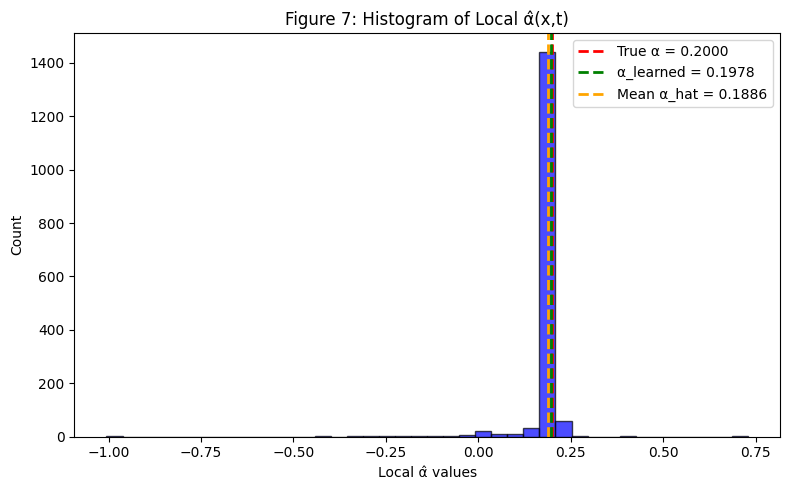

In [200]:
# --------------------------------------------------------
# HISTOGRAM OF LOCAL alpha_hat VALUES
# --------------------------------------------------------
# Treat α as a function ONLY for diagnostic purposes.

plt.figure(figsize=(8,5))
plt.hist(alpha_hat_vals, bins=40, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(alpha_true, color='red', linestyle='--', linewidth=2, label=f"True α = {alpha_true:.4f}")
plt.axvline(alpha_learned, color='green', linestyle='--', linewidth=2, label=f"α_learned = {alpha_learned:.4f}")
plt.axvline(alpha_hat_mean, color='orange', linestyle='--', linewidth=2, label=f"Mean α_hat = {alpha_hat_mean:.4f}")

plt.xlabel("Local α̂ values")
plt.ylabel("Count")
plt.title("Figure 7: Histogram of Local α̂(x,t)")
plt.legend()
plt.tight_layout()
plt.show()


#### **Figure 7: Histogram of Local Diffusivity Estimates $\;\widehat{\alpha}(x,t)$**

The local estimates of diffusion coefficient, $\widehat{\alpha}$ are compared with alpha_true and alpha_learned.
$$\quad$$
This histogram of $\;\widehat{\alpha}(x,t)\;$ shows that the PINN enforces the heat-equation structure consistently across the domain. Most of the local $\widehat{\alpha}$ estimates cluster tightly around the true value $\alpha = 0.20$ and the learned value $\alpha$_learned ≈ 0.198, with only small numerical outliers. The tall, narrow peak indicates strong PDE consistency and confirms that the PINN successfully solved the inverse problem.


---

**Note:** We treat $\widehat{\alpha}\;$ as a function ONLY for diagnostic purposes.
We compute an estimate of $\widehat{\alpha}\;$ at every point in space-time to check if the model behaves like a $\;\alpha$-constant  system.

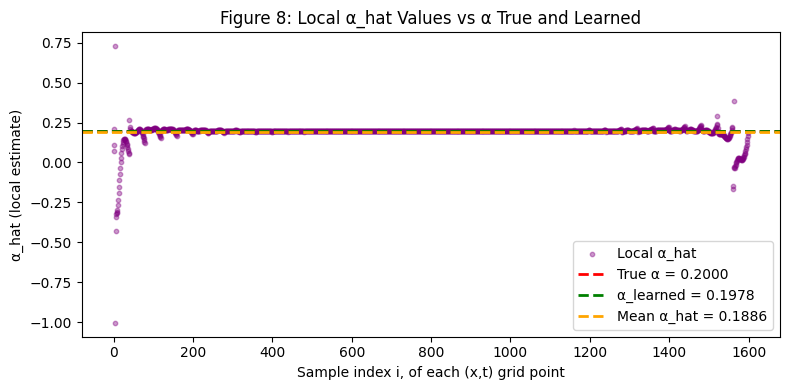

In [201]:
# -----------------------------------------------------------
# Scatter Plat of alpha_hat VS alpha_true and alpha_learned
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
plt.scatter(range(len(alpha_hat_vals)), alpha_hat_vals,
            s=10, color='purple', alpha=0.4, label='Local α_hat')
plt.axhline(alpha_true, color='red', linestyle='--', linewidth=2, label=f"True α = {alpha_true:.4f}")
plt.axhline(alpha_learned, color='green', linestyle='--', linewidth=2, label=f"α_learned = {alpha_learned:.4f}")
plt.axhline(alpha_hat_mean, color='orange', linestyle='--', linewidth=2, label=f"Mean α_hat = {alpha_hat_mean:.4f}")

plt.title("Figure 8: Local α_hat Values vs α True and Learned")
plt.xlabel("Sample index i, of each (x,t) grid point")
plt.ylabel("α_hat (local estimate)")
plt.legend()
plt.tight_layout()
plt.show()

#### **Figure 8: Scatter Plot of local $\;\widehat{\alpha}\;$**

Each point in Figure 8 corresponds to one grid location $(x_i,t_i)$
in the domain where a local estimate $\;\widehat{\alpha}(x_i,t_i)\;$ was computed. The 2D $\;(x,t)\;$ grid is flattened into a single list, so the horizontal axis is simply the sample index $i$. This plot illustrates the variation of the local estimates $\;\widehat{\alpha}\;$ across the domain and how closely they align with the true diffusivity and the PINN-learned value.
$$\qquad$$
**Note: The extreme $\widehat{\alpha}$ values near the start and end of the plot are expected** and come from boundary regions where the second derivative
$T_{xx}$ is close to zero. Since

$$\widehat{\alpha} \; = \frac{T_t(x,t) - Q(x,t)}{ T_{xx}(x,t)}$$

 dividing by a very small number leads to large deviations. This is a normal side-effect of local least-squares estimation and does not indicate model instability.


---





In [211]:
# --------------------------------------------------------
# Local alpha_hat statistics
# --------------------------------------------------------
eps = 1e-3
mask = np.abs(T_xx_np) > eps

alpha_hat_vals = (T_t_np[mask] - Q_np[mask]) / T_xx_np[mask]
alpha_hat_mean = float(np.mean(alpha_hat_vals))
alpha_hat_std  = float(np.std(alpha_hat_vals))

print("\n" + "="*70)
print("POST-PROCESSING: PDE Parameter (alpha) Analysis")
print("="*70)

print("\n=== Local alpha_hat(x,t) samples ===")
print(alpha_hat_vals[90:120])

print("\n=== alpha statistics ===")
print(f"Mean alpha_hat: {alpha_hat_mean:.6f}")
print(f"Std  alpha_hat: {alpha_hat_std:.6f}")

print("\n=== Comparison with ground truth alpha ===")
print(f"True alpha:      {alpha_true:.6f}")
print(f"|alpha_hat_mean - alpha_true| = {abs(alpha_hat_mean - alpha_true):.6f}")

# Step 5: residual diagnostics (use learned alpha)
R_np = T_t_np - alpha_learned * T_xx_np - Q_np

print("\n=== PDE Residual Diagnostics ===")
print(f"Residual mean: {np.mean(R_np):.6e}")
print(f"Residual std:  {np.std(R_np):.6e}")
print(f"Residual max:  {np.max(np.abs(R_np)):.6e}")

print("\n=== Learned alpha from training ===")
print(f"True alpha:           {alpha_true:.6f}")
print(f"Learned alpha_param:  {alpha_learned:.6f}")
print(f"Percent error:        {alpha_err_pct:.3f}%")


POST-PROCESSING: PDE Parameter (alpha) Analysis

=== Local alpha_hat(x,t) samples ===
[0.20637271 0.20542246 0.2047509  0.20444435 0.20454201 0.20503514
 0.20588064 0.20700741 0.20832703 0.20973767 0.21113548 0.21241294
 0.21346916 0.21421218 0.21455577 0.2144311  0.21377905 0.21255441
 0.21072617 0.2082756  0.20519316 0.20148118 0.1971493  0.19221397
 0.18669751 0.1806245  0.1740235  0.16692719 0.15936656 0.15137461]

=== alpha statistics ===
Mean alpha_hat: 0.188605
Std  alpha_hat: 0.060766

=== Comparison with ground truth alpha ===
True alpha:      0.200000
|alpha_hat_mean - alpha_true| = 0.011395

=== PDE Residual Diagnostics ===
Residual mean: 2.971480e-04
Residual std:  8.175609e-03
Residual max:  6.256828e-02

=== Learned alpha from training ===
True alpha:           0.200000
Learned alpha_param:  0.197777
Percent error:        1.111%


In [217]:
# ================================================
# Baseline NN vs PINN
# ================================================

# 1) Train a baseline neural network (data-only, no physics)
def train_baseline(model, optimizer, epochs):
    losses = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # data-only loss
        T_pred = model(x_data, t_data)
        loss = mse_loss(T_pred, T_data)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"[Baseline] Epoch {epoch:5d} | Data loss: {loss.item():.4e}")

    return losses

baseline_epochs = 5000  # adjust if needed
baseline_model = Net(layers).to(device)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

print("\n" + "="*60)
print("Training baseline (data-only) neural network")
print("="*60)
baseline_losses = train_baseline(baseline_model, baseline_optimizer, baseline_epochs)


# 2) Compute MSE for both models on the same evaluation grid
def compute_mse_on_grid(model_to_eval):
    # build evaluation grid (nx, nt values can be changed)
    nx_eval, nt_eval = 80, 120
    x_eval = torch.linspace(0.0, L, nx_eval).view(-1, 1)
    t_vals_eval = torch.linspace(0.0, T_final, nt_eval)

    Xg_eval = x_eval.repeat(1, nt_eval)
    Tg_eval = t_vals_eval.repeat(nx_eval, 1)

    x_flat = Xg_eval.reshape(-1, 1).to(device)
    t_flat = Tg_eval.reshape(-1, 1).to(device)

    with torch.no_grad():
        T_true = analytic_solution(x_flat, t_flat)
        T_pred = model_to_eval(x_flat, t_flat)

    T_true_np = T_true.cpu().numpy()
    T_pred_np = T_pred.cpu().numpy()

    mse = np.mean((T_pred_np - T_true_np) ** 2)
    return mse


Training baseline (data-only) neural network
[Baseline] Epoch     0 | Data loss: 1.9965e-01
[Baseline] Epoch   500 | Data loss: 4.0599e-03
[Baseline] Epoch  1000 | Data loss: 4.0993e-04
[Baseline] Epoch  1500 | Data loss: 7.6476e-05
[Baseline] Epoch  2000 | Data loss: 2.7752e-05
[Baseline] Epoch  2500 | Data loss: 1.9926e-05
[Baseline] Epoch  3000 | Data loss: 3.4622e-05
[Baseline] Epoch  3500 | Data loss: 5.4692e-05
[Baseline] Epoch  4000 | Data loss: 5.3758e-06
[Baseline] Epoch  4500 | Data loss: 3.0694e-06
[Baseline] Epoch  4999 | Data loss: 1.6468e-06



Figure 9: Baseline Neural Network vs. PINN Compared to the Analytic Solution


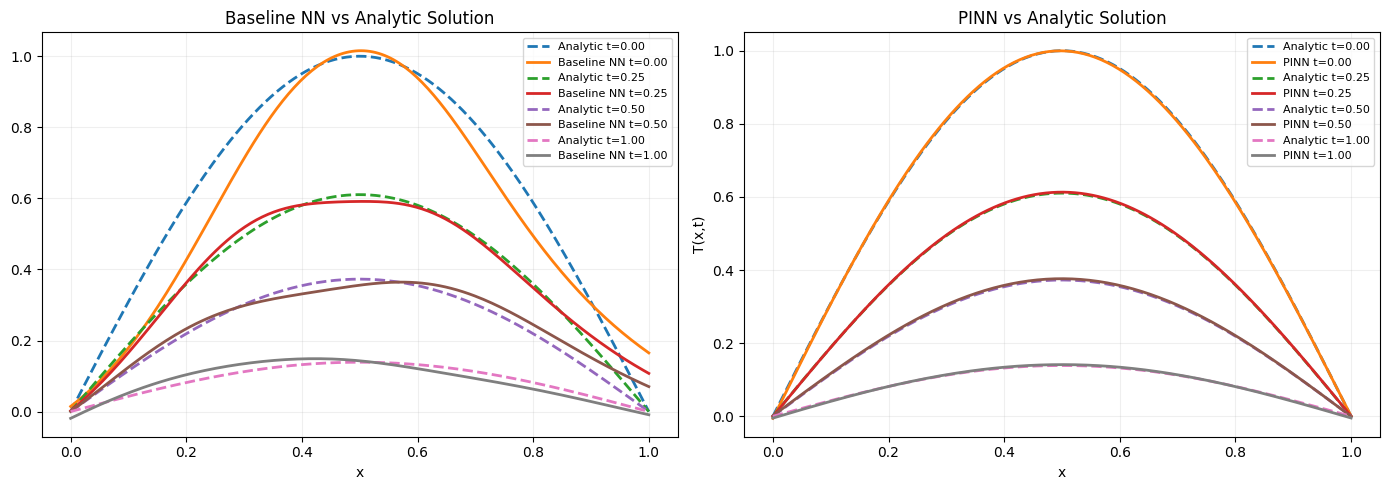

In [238]:
# ============================================================
# Side-by-Side Comparison:
#   Left → Baseline NN vs Analytic Solution
#   Right  → PINN vs Analytic Solution
# ============================================================

x_plot = torch.linspace(0, L, 200).view(-1, 1).to(device)
times_to_plot = [0.0, 0.25 * T_final, 0.5 * T_final, T_final]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------
# LEFT: Baseline NN vs Analytic
# -----------------------------
baseline_model.eval()

for t_val in times_to_plot:
    t_plot = torch.full_like(x_plot, t_val).to(device)

    with torch.no_grad():
        T_base = baseline_model(x_plot, t_plot).cpu().numpy().flatten()
        T_true = analytic_solution(x_plot.cpu(), t_plot.cpu()).numpy().flatten()

    ax1.plot(
        x_plot.cpu().numpy(), T_true,
        linestyle="--", linewidth=2,
        label=f"Analytic t={t_val:.2f}")

    ax1.plot(
        x_plot.cpu().numpy(), T_base,
        linestyle="-", linewidth=2,
        label=f"Baseline NN t={t_val:.2f}")

ax1.set_title("Baseline NN vs Analytic Solution")
ax1.set_xlabel("x")
ax1.grid(alpha=0.2)
ax1.legend(fontsize=8)

# -----------------------------
# RIGHT: PINN vs Analytic
# -----------------------------
for t_val in times_to_plot:
    t_plot = torch.full_like(x_plot, t_val).to(device)

    with torch.no_grad():
        T_pinn = model(x_plot, t_plot).cpu()
        T_true = analytic_solution(x_plot.cpu(), t_plot.cpu())

    ax2.plot(
        x_plot.cpu().numpy(), T_true.numpy(),
        linestyle="--", linewidth=2,
        label=f"Analytic t={t_val:.2f}")

    ax2.plot(
        x_plot.cpu().numpy(), T_pinn.numpy(),
        linestyle="-", linewidth=2,
        label=f"PINN t={t_val:.2f}")
print("\n" + "="*80)
print("Figure 9: Baseline Neural Network vs. PINN Compared to the Analytic Solution")
print("="*80)

ax2.set_title("PINN vs Analytic Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("T(x,t)")
ax2.grid(alpha=0.2)
ax2.legend(fontsize=8)
plt.tight_layout()
plt.show()

### **Figure 9: Baseline Neural Network vs. PINN Compared to the Analytic Solution.**

These plots compare the temperature predictions $T(x,t)\;$ from a standard feed-forward neural network (left) and the Physics-Informed Neural Network (right) against the true analytic solution of the 1D heat equation. Four time slices are shown: $t=0, 0.25, 0.5, 1.00$

The baseline NN, trained only on noisy data, exhibits noticeable deviation from the true solution, especially at intermediate times. In contrast, the PINN closely matches the analytic curves for all time slices by enforcing the PDE, the initial condition, and the boundary conditions during training. This demonstrates the strong accuracy advantage of PINNs when data are sparse or noisy.


Figure 10: Error Comparison Between Baseline Neural Network and PINN


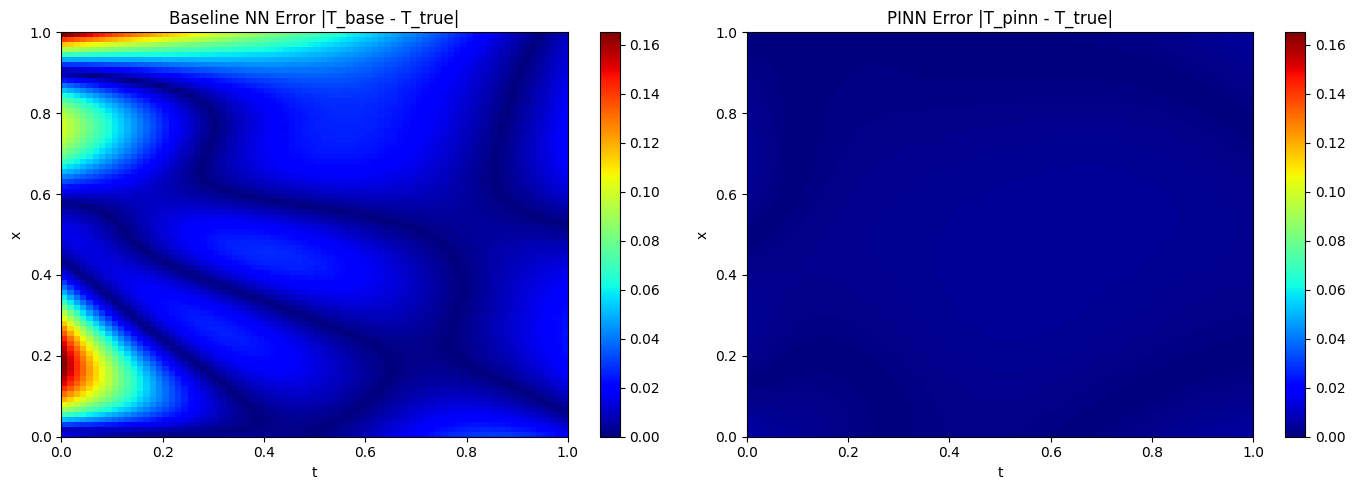

In [242]:
# ============================================================
# Baseline NN and PINN Error Heatmaps (side by side)
# ============================================================
print("\n" + "="*80)
print("Figure 10: Error Comparison Between Baseline Neural Network and PINN")
print("="*80)

baseline_model.eval()
model.eval()

# Evaluation grid
Nx, Nt = 80, 80
x_vals = torch.linspace(0.0, L, Nx).view(-1, 1).to(device)
t_vals = torch.linspace(0.0, T_final, Nt).view(-1, 1).to(device)

Xg, Tg = torch.meshgrid(x_vals.squeeze(), t_vals.squeeze(), indexing="ij")
x_eval = Xg.reshape(-1, 1).to(device)
t_eval = Tg.reshape(-1, 1).to(device)

with torch.no_grad():
    # True solution
    T_true = analytic_solution(x_eval.cpu(), t_eval.cpu()).numpy().flatten()

    # Baseline NN prediction
    T_base = baseline_model(x_eval, t_eval).cpu().numpy().flatten()

    # PINN prediction
    T_pinn = model(x_eval, t_eval).cpu().numpy().flatten()

# Compute absolute errors
baseline_err = np.abs(T_base - T_true)
pinn_err     = np.abs(T_pinn - T_true)

# Reshape into grids
baseline_err_mat = baseline_err.reshape(Nx, Nt)
pinn_err_mat     = pinn_err.reshape(Nx, Nt)

# -------------------------------
# Force SAME COLOR SCALE
# -------------------------------
vmin = 0.0
vmax = baseline_err_mat.max()   # use baseline max to reveal contrast

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# ----------------------------------------------------------
# Left plot: Baseline error heat map
# ----------------------------------------------------------
im1 = ax1.imshow(
    baseline_err_mat,
    extent=[0, T_final, 0, L],
    origin='lower',
    aspect='auto',
    cmap='jet',
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Baseline NN Error |T_base - T_true|")
ax1.set_xlabel("t")
ax1.set_ylabel("x")
fig.colorbar(im1, ax=ax1)

# ----------------------------------------------------------
# Right plot: PINN error heat map
# ----------------------------------------------------------
im2 = ax2.imshow(
    pinn_err_mat,
    extent=[0, T_final, 0, L],
    origin='lower',
    aspect='auto',
    cmap='jet',
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("PINN Error |T_pinn - T_true|")
ax2.set_xlabel("t")
ax2.set_ylabel("x")
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

### **Figure 10: Error Comparison Between Baseline Neural Network and PINN**

The left panel shows the baseline neural network's error heatmap, which has large regions of high error (yellow/red) and strong spatial-temporal oscillations. Because the baseline model is trained only on the noisy data points, it struggles to generalize across the domain, leading to errors as high as 0.16.

The right panel shows the PINN prediction error. The plot is almost entirely dark blue, indicating that

$$|T_{PINN​}-T_{true​}| \approx 10^{-3} \;\text{to}\; 10^{-2}$$

with no high error regions. This smooth error landscape reveals that the PINN learned a physically consistent solution by enforcing the heat-equation residual during training.

Overall, the comparison demonstrates that the **PINN dramatically outperforms the baseline neural network, reducing global prediction error** by more than an order of magnitude while recovering the correct heat-diffusion behavior across the entire domain.

In [233]:
# ======================================================
# Compute and print Baseline NN percentage improvement
# ======================================================
mse_baseline = compute_mse_on_grid(baseline_model)  # data-only NN
mse_pinn     = compute_mse_on_grid(model)          # our trained PINN

improvement_pct = 100.0 * (mse_baseline - mse_pinn) / mse_baseline

print("\n=== Baseline vs PINN Comparison (Heat Equation) ===")
print(f"Baseline MSE (data-only NN): {mse_baseline:.6e}")
print(f"PINN MSE (with physics):     {mse_pinn:.6e}")
print(f"Relative error reduction:    {improvement_pct:.2f}%")



=== Baseline vs PINN Comparison (Heat Equation) ===
Baseline MSE (data-only NN): 9.705968e-04
PINN MSE (with physics):     4.881870e-06
Relative error reduction:    99.50%


# Conclusion

---

In this project, we used a Physics-Informed Neural Network (PINN) to learn the solution of the 1D heat equation from sparse and noisy measurements. The model successfully reconstructed the full temperature field $T(x,t)$

while simultaneously enforcing the governing PDE, the initial condition, and the boundary conditions.

The PINN also recovered the true thermal diffusivity parameter with high accuracy:


*   True $\alpha = 0.2$
*   Learned $\alpha = 0.197777$. $\;$ (**$\approx$ 1.111% error)**
$$\quad$$

Post-processing diagnostics showed that the estimated diffusivity
$\;\widehat{\alpha}(x,t)$ was tightly concentrated around the true value, and the PDE residuals clustered around zero, indicating that the learned solution remains physically consistent throughout the domain.

Compared to a baseline neural network trained only on noisy measurements, the **PINN reduced the prediction error by 99.5%**, demonstrating that incorporating the physics constraints dramatically improves generalization and stability.
